In [ ]:
import pandas as pd
import numpy as np

# lib for handling the data at physionet
import wfdb
# for use with utility functions in wfdb
from wfdb import processing

# for creating a buffer to store the image arrays
from io import BytesIO
# for creating the image buffer
from PIL import Image
# creates the image
import matplotlib.pyplot as plt

Refs  
https://wfdb.readthedocs.io/en/latest/io.html#wfdb-annotations

In [2]:
# get the data
def load_data(record_name, path='mitdb', extension='atr'):
    '''
    requirements:
        wfdb
        numpy
        
    params:
        record_name (str) the record name as per physionet database
            these can be found by searching using wfdb.io.get_record_list(db_dir, , records='all')
        path (str) the path on physionet eg 'mitdb' search using wfdb.io.get_dbs()
        extension (str) the file extension of the annotation file eg 'atr'

    returns:
        (np.array) the signal data of n channels
        (dict) a dict containing the meta data for the singnal such as sampling rate
        (np.array) a 2d array containing the labels and their respective position at sample number n
    '''
    # get the 2d signal array from channel 0 which is the p signal
    signal, fields = wfdb.rdsamp(record_name=record_name, pn_dir=path, channels=[0])
    # the annotations
    annotations = wfdb.rdann(record_name=record_name, extension=extension, pn_dir=path)
    
    return signal, fields, annotations

In [3]:
def get_mean_heartrate(signal, fields):
    '''
    requirements:
        wfdb.processing
        wfdb
        numpy
        
    params:
        (np.array) the signal data of n channels
        (dict) a dict containing the meta data for the singnal such as sampling rate
        
    returns:
        (float) the mean heart rate
            
    '''
    # find the qrs locations for computing the HR
    xqrs = processing.XQRS(sig=signal[:,0], fs=fields['fs'])
    xqrs.detect(verbose=False)
    # get the heart rate at each QRS
    hr = wfdb.processing.compute_hr(sig_len=fields['sig_len'], qrs_inds=xqrs.qrs_inds, fs=fields['fs'])
    # the mean length in samples of the heart rate which ought to correspond to the RR length
    mean = (np.nanmean(hr) / 60) * fields['fs']
    
    return mean

In [94]:
# convert to an image array of size 454, 340 the width of the array
# and reduce to a single color channel
def get_image_array(data):
    '''
    requirements:
        BytesIO
        matplotlib.pyplot
        
    params:
        (np.array) data 
    '''
    # shape plot to match the x dim to reduce data size
    # the y is based on the default aspect ratio since the heights can vary
    dpi = 100
#     aspect = 1.333 # that used by defaut with the plot
    width = 362
    height = 281
    
    # create plot
    fig, ax = plt.subplots(figsize=(width/dpi, height/dpi))
    plt.plot(data)
#     pd.DataFrame(data).plot(
#         ax=ax, cmap='gray', legend=False,
#         figsize=(width/dpi, height/dpi)
#     )
#     pd.DataFrame(data).plot(ax=ax, cmap='gray', legend=False)
    plt.axis('off')
    
    # save plot to a buffer for export
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # close fig to free memory 
    plt.close(fig)

    # Convert the image to a numpy array and save only one colour channel
    # color is of no use since the images have been recreated from x, y data only
    img_array = np.array(Image.open(buf))[:, :, 0:1]
#     print(img_array.shape)
    # Close the buffer
    buf.close()
    
    return img_array

In [46]:
def separate_hearbeats(signal, annotations, mean_rate, supergroup_classes):
    '''
    params:
        annotations (np.array) the single letter annotations for each QRS
        mean_rate (float) the mean heart rate of a given series
            this is used to create a window either side of the annotation location
            from which to slice each sample
        supergroup_classes (dict) classes to include in the result
    returns:
        (np.array) a set of 2d images each representing a single hearbeat
    '''
    signal_images = []
    labels = []
    
    # create a frame in samples to slice either side of the peak
    scale_factor = 0.8
    # scale to ensure shorter beats in arrhythmias do not contain more than one QRS
    frame = int((mean_rate * scale_factor) / 2) 
    # loop through and get each not matching the filter
    signal = np.array(signal[:, 0])
    for i, pos in enumerate(annotations.sample):
#         if annotations.symbol[i] != filters:
        if annotations.symbol[i] in supergroup_classes:
            signal_images.append(signal[pos - frame: pos + frame])
#             labels.extend(annotations.symbol[i])
            #s = super_group_classes[annotations.symbol[i]]
#             print(s)
            labels.append(supergroup_classes[annotations.symbol[i]])
            
    return signal_images, labels

In [6]:
# defines the database within physionet
path='mitdb'
# filename to save data to file
file_name = path
# get a full list of the record names from physionet
record_names = wfdb.io.get_record_list(db_dir=path)

In [7]:
# dict to generalise the classes into the 5 main supergroups
supergroups_exc_n = {
#     supraventricular
    'A': 0,'a': 0,'J': 0,'S': 0,'e': 0,'j': 0,'n': 0,
#     ventricular
    'V': 1,'r': 1,'E': 1,
#     fusion
    'F': 2,'f': 2,
#     unknown
    'Q': 3,'?': 3,
#     normal
#     'N': 4   
}

supergroups_inc_n = {
#     normal
    'N': 4   
}

## Convert data to image arrays
Steps:  
- load all data excluding the normal which is causes a large imbalance in the data. do this by editing the supergroup_classes dict
- select record 1 and load only the normal class data from there. Again done by editing the supergroup_classes dict.


In [98]:
class process_data:
    
    def __init__(self):
        self.__image_arrays = []
        self.__label_strings = []
        
    def create_img_arrays(self, supergroup_classes, record_names):
        
        print(f"|Total records: {len(record_names)}")
        print(f"|Classes: {set(supergroup_classes.values())}")
        
        # skip odd sized and empty arrays at the start and end
        # to prevent a jagged array being attempted
        start = 2
        end = -1

        for record_name in record_names:
            # get signal and label data
            print(f"|Loading: {record_name} ", end="")
            signal, fields, annotations = load_data(record_name=record_name)
            # get the mean heartrate for the record
            mean = get_mean_heartrate(signal, fields)
            print(f"|Mean HR: {mean:.2f} ", end="")

            # split the heartbeats and get labels
            beats, labels = separate_hearbeats(signal, annotations, mean, supergroup_classes)
            # confirm a matching set of labels and beats
            assert len(beats) == len(labels), "Mismatch in labels and images"

            self.__label_strings.extend(labels[start: end])
            print(f"|Len beats: {len(beats)}\t, labels: {len(labels)}\t|")

            imgs = np.array([get_image_array(beat) for beat in beats[start: end]])
            self.__image_arrays.extend(imgs)
        
    @property
    def image_arrays(self):
        return np.array(self.__image_arrays)
    
    @property
    def label_strings(self):
        return np.array(self.__label_strings)

In [99]:
p = process_data()
# records from all sets excluding those in class N
p.create_img_arrays(supergroups_exc_n, record_names)
# records from the first set with only those in class N
p.create_img_arrays(supergroups_inc_n, record_names[0:1])

|Total records: 48
|Classes: {0, 1, 2, 3}
|Loading: 100 |Mean HR: 454.73 |Len beats: 34	, labels: 34	|
|Loading: 101 |Mean HR: 373.63 |Len beats: 5	, labels: 5	|
|Loading: 102 |Mean HR: 436.42 |Len beats: 60	, labels: 60	|
|Loading: 103 |Mean HR: 415.58 |Len beats: 2	, labels: 2	|
|Loading: 104 |Mean HR: 449.30 |Len beats: 686	, labels: 686	|
|Loading: 105 |Mean HR: 527.60 |Len beats: 46	, labels: 46	|
|Loading: 106 |Mean HR: 458.34 |Len beats: 520	, labels: 520	|
|Loading: 107 |Mean HR: 426.55 |Len beats: 59	, labels: 59	|
|Loading: 108 |Mean HR: 453.44 |Len beats: 24	, labels: 24	|
|Loading: 109 |Mean HR: 505.93 |Len beats: 40	, labels: 40	|
|Loading: 111 |Mean HR: 423.90 |Len beats: 1	, labels: 1	|
|Loading: 112 |Mean HR: 506.43 |Len beats: 2	, labels: 2	|
|Loading: 113 |Mean HR: 360.02 |Len beats: 6	, labels: 6	|
|Loading: 114 |Mean HR: 380.71 |Len beats: 59	, labels: 59	|
|Loading: 115 |Mean HR: 390.46 |Len beats: 0	, labels: 0	|
|Loading: 116 |Mean HR: 488.64 |Len beats: 110	, la

In [103]:
label_strings = p.label_strings
image_arrays = p.image_arrays
print(f"Images: {image_arrays.shape}\nLabels: {label_strings.shape}")

Images: (14190, 281, 362, 1)
Labels: (14190,)


In [101]:
# save the results
np.save(f'{file_name}_data_reduced', p.image_arrays)
np.save(f'{file_name}_labels_reduced', p.label_strings)

In [104]:
# calculate the probability of using simple random guesses
# this is used as the baseline for statistical significance

count = 0
class_counts = np.histogram(label_strings, bins=(0,1,2,3,4,5))
counts = np.append(class_counts[-1][:-1].tolist(), class_counts[0])
counts = np.transpose(counts.reshape((2, 5)), axes=None)

t1 = f"Class"
t2 = f"Count"
line = "|---------------------|"
print(f"|{t1:^10}|{t2:^10}|")
print(line)

for pair in counts:
    output = f"|{pair[0]: ^10}|{pair[1]:^10}|"
    print(output)

print(line)
print(f"|Total{len(label_strings): >13}   |")

for label in label_strings:
    if np.random.randint(5) == label:
        count += 1
    
prob = (count / len(label_strings)) * 100
print(f"|Probability {prob: >6.2f}%  |")

|  Class   |  Count   |
|---------------------|
|    0     |   2983   |
|    1     |   7165   |
|    2     |   1774   |
|    3     |    32    |
|    4     |   2236   |
|---------------------|
|Total        14190   |
|Probability  19.95%  |


In [ ]:
wfdb.io.show_ann_labels()

## Supergroups [cite]

### Normal
- **Normal beat (N)**

### Supraventricular
- **Atrial premature beat (A)**
- **Aberrated atrial premature beat (a)**
- **Nodal (junctional) premature beat (J)**
- **Supraventricular premature or ectopic beat (S)**
- **Atrial escape beat (e)**
- **Nodal (junctional) escape beat (j)**
- **Supraventricular escape beat (n)**

### Ventricular
- **Premature ventricular contraction (V)**
- **R-on-T premature ventricular contraction (r)**
- **Ventricular escape beat (E)**

### Fusion
- **Fusion of ventricular and normal beat (F)**
- **Fusion of paced and normal beat (f)**

### Unknown
- **Unclassifiable beat (Q)**
- **Beat not classified during learning (learning) (?)**

## Redundant Code

In [ ]:
# split the labels and index locations to allow conversion to one hot encoding for the classes
labels = annotations.symbol
# used to match the annotations to the peaks since there are missing annotations and
# thus cannot simply take all QRS and expect the labels to line up
label_indices = annotations.sample

In [ ]:
# get a test set of 106 which on the physionet display has type V
signal, fields = wfdb.rdsamp(record_name="106", pn_dir=path, channels=[0])
# the annotations
annotations = wfdb.rdann(record_name=record_name, extension='atr', pn_dir=path)

In [ ]:
# confirm has type V
labels = np.array(annotations.symbol)
np.unique(labels)

In [ ]:
# using the sep function still returns type V
mean = get_mean_heartrate(signal, fields)
b, l = separate_hearbeats(signal, annotations, mean, filters="N")

np.unique(np.array(l))

# why not showing up in the main loop?

In [ ]:
len(labels)

In [ ]:
rr = wfdb.processing.calc_rr(qrs_locs=signal, rr_units='seconds', fs=360.0)

In [ ]:
i = 1000
window_len = 100
window = rr[i - window_len: i]

print(f"mean:\t{window.mean()}\nstd: \t{window.std()}\nmin: {window.min()}\nmax: {window.max()}")

In [ ]:
print(rr[:25])

In [ ]:
# get the heart rate at each QRS
heart_rates = wfdb.processing.compute_hr(sig_len=fields['sig_len'], qrs_inds=xqrs.qrs_inds, fs=fields['fs'])

In [ ]:
# the mean length in samples of the heart rate which ought to correspond to the RR length
meanrate = (np.nanmean(heart_rates) / 60) * fields['fs']
meanrate

In [ ]:
frame = int(meanrate / 2)
# extract the single p signal and slice by frame width
signal_images = [np.array(signal[:, 0])[i - frame: i + frame] for i in label_indices]

In [ ]:
plt.plot(signal_images[8])

In [ ]:
sample = signal[0:200, 0]
plt.plot(sample)

In [ ]:
var = np.poly1d(sample.flatten())

In [ ]:
derivative = var.deriv()

In [ ]:
sd = derivative(sample)

In [ ]:
plt.plot(sd[75:90])

In [ ]:
# def separate_hearbeats(signal, label_indices, mean_rate):
#     '''
#     params:
#         mean_rate (float) the mean heart rate of a given series
#             this is used to create a window either side of the annotation location
#             from which to slice each sample
#     returns:
#         (np.array) a set of 2d images each representing a single hearbeat
#     '''
#     # create a frame in samples to slice either side of the peak
#     frame = int(mean_rate / 2)
#     # extract the single p signal and slice by frame width
#     signal_images = [
#         np.array(signal[:, 0])[i - frame: i + frame] for i in label_indices]

#     return signal_images

In [80]:
def get_image_array_test(data):

    dpi = 100
    width = 454
    height = 340

    fig, ax = plt.subplots(figsize=(width/dpi, height/dpi))
#     pd.DataFrame(data).plot(
    plt.plot(data)
    plt.axis('off')

    # save plot to a buffer for export
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # close fig to free memory 
    plt.close(fig)

    # Convert the image to a numpy array and save only one colour channel
    # color is of no use since the images have been recreated from x, y data only
    img_array = np.array(Image.open(buf))[:, :, 0:1]
    print(img_array.shape)
    # Close the buffer
    buf.close()
    
    return img_array

In [ ]:
# print(f"|Total records: {len(record_names)}")

# # skip odd sized and empty arrays at the start and end
# # to prevent a jagged array being attempted
# start = 2
# end = -1

# for record_name in record_names:
#     # get signal and label data
#     print(f"|Loading: {record_name} ", end="")
#     signal, fields, annotations = load_data(record_name=record_name)
#     # get the mean heartrate for the record
#     mean = get_mean_heartrate(signal, fields)
#     print(f"|Mean HR: {mean:.2f} ", end="")

#     # split the heartbeats and get labels
#     beats, labels = separate_hearbeats(signal, annotations, mean, supergroup_classes)
#     # confirm a matching set of labels and beats
#     assert len(beats) == len(labels), "Mismatch in labels and images"
    
#     label_strings.extend(labels[start: end])
#     print(f"|Len beats: {len(beats)}\t, labels: {len(labels)}|")
    
#     imgs = np.array([get_image_array(beat) for beat in beats[start: end]])
#     img_arrays.extend(imgs)

In [ ]:
# the individual beats and labels
# label_strings = []
# img_arrays = []

In [12]:
signal, fields, annotations = load_data(record_name='100')

In [13]:
mean = get_mean_heartrate(signal, fields)

In [33]:
supergroups = {
#     supraventricular
    'A': 0,'a': 0,'J': 0,'S': 0,'e': 0,'j': 0,'n': 0,
#     ventricular
    'V': 1,'r': 1,'E': 1,
#     fusion
    'F': 2,'f': 2,
#     unknown
    'Q': 3,'?': 3,
# #     normal
#     'N': 4   
}

In [47]:
beats, labels = separate_hearbeats(signal, annotations, mean, supergroups)

In [81]:
i = get_image_array_test(beats[4])

(340, 454, 1)


In [87]:
beats[3].shape[0]

362

(-18.05, 379.05, -0.60175, 0.97675)

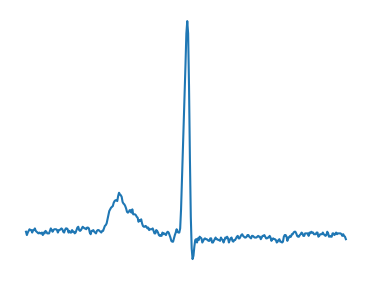

In [79]:
fig, ax = plt.subplots(figsize=(454/100, 340/100))
plt.plot(beats[3])
plt.axis('off')

In [106]:
import math
50 * (math.log(50, 3)**2)

633.9921774610772

In [ ]:
# img.shape